In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, \
    KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, roc_curve, confusion_matrix

%config InlineBackend.figure_format = 'png'
%matplotlib inline
sns.set(color_codes=True)
plt.style.use('seaborn-colorblind')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)

## Data Loading ##

In [588]:
with open('pickles/feature_engineering_sample_df7.pickle', 'wb') as to_write:
    pickle.dump(sample_df, to_write)

In [428]:
with open('pickles/cv_records_df.pickle', 'wb') as to_write:
    pickle.dump(cv_records, to_write)

In [486]:
with open('pickles/combined_error_analysis_df.pickle', 'wb') as to_write:
    pickle.dump(combined_error_analysis_df, to_write)

In [497]:
with open('pickles/feature_engineering_sample_df5.pickle', 'rb') as read_file:
    sample_df = pickle.load(read_file)

In [498]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 77 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   year                                      100000 non-null  int64  
 1   month                                     100000 non-null  int64  
 2   day                                       100000 non-null  int64  
 3   day_of_week                               100000 non-null  int64  
 4   airline                                   100000 non-null  object 
 5   flight_number                             100000 non-null  int64  
 6   tail_number                               99757 non-null   object 
 7   origin_airport                            100000 non-null  object 
 8   destination_airport                       100000 non-null  object 
 9   scheduled_departure                       100000 non-null  object 
 10  departure_time       

In [6]:
with open('cv_records.pickle', 'rb') as read_file:
    cv_records = pickle.load(read_file)

In [7]:
cv_records

[{'model': 'logistic',
  'iteration_desc': 'baseline',
  'feature_engineering': '',
  'hyperparameter_tuning': '',
  'mean_train_f1': 0.0,
  'mean_val_f1': 0.0,
  'mean_train_precision': 0.0,
  'mean_val_precision': 0.0,
  'mean_train_recall': 0.0,
  'mean_val_recall': 0.0,
  'mean_train_accuracy': 0.8326874999999999,
  'mean_val_accuracy': 0.8326875000000001}]

In [236]:
sample_df['is_not_on_time'] = np.where((sample_df['arrival_delay'] >= 15) | (sample_df['diverted'] == 1) |
                                       (sample_df['cancelled'] == 1), 1, 0)

In [237]:
sample_df.is_not_on_time.value_counts()

0    79873
1    20127
Name: is_not_on_time, dtype: int64

In [4]:
sample_df.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time
0,2015,2,13,5,EV,4210,N26141,IAH,BNA,1904,1900,-4.0,18.0,1918,107,113.0,89.0,657,2047,6.0,2051,2053,2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,Nashville International Airport,Nashville,TN,36.12,-86.68,0
1,2015,6,21,7,WN,511,N7714B,DEN,CMH,1835,1831,-4.0,11.0,1842,165,157.0,140.0,1154,2302,6.0,2320,2308,-12.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,Denver International Airport,Denver,CO,39.86,-104.67,Port Columbus International Airport,Columbus,OH,40.00,-82.89,0
2,2015,2,18,3,AA,1271,N3ESAA,SNA,DFW,1217,1210,-7.0,12.0,1222,168,168.0,139.0,1205,1641,17.0,1705,1658,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,John Wayne Airport (Orange County Airport),Santa Ana,CA,33.68,-117.87,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,32.90,-97.04,0
3,2015,8,26,3,DL,1925,N963DN,ATL,BWI,0730,0729,-1.0,16.0,0745,110,104.0,81.0,577,0906,7.0,0920,0913,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,33.64,-84.43,Baltimore-Washington International Airport,Baltimore,MD,39.18,-76.67,0
4,2015,6,1,1,WN,3301,N793SA,SAT,DAL,1250,1244,-6.0,11.0,1255,60,64.0,48.0,248,1343,5.0,1350,1348,-2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,San Antonio International Airport,San Antonio,TX,29.53,-98.47,Dallas Love Field,Dallas,TX,32.85,-96.85,0


In [5]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   year                           100000 non-null  int64  
 1   month                          100000 non-null  int64  
 2   day                            100000 non-null  int64  
 3   day_of_week                    100000 non-null  int64  
 4   airline                        100000 non-null  object 
 5   flight_number                  100000 non-null  int64  
 6   tail_number                    99757 non-null   object 
 7   origin_airport                 100000 non-null  object 
 8   destination_airport            100000 non-null  object 
 9   scheduled_departure            100000 non-null  object 
 10  departure_time                 98518 non-null   object 
 11  departure_delay                98518 non-null   float64
 12  taxi_out                       

## Functions ##

In [8]:
def initial_split(X, y):
    """Splits features and target dataframes in 80/20 ratio.

    Args:
        X: A dataframe only consisting of the features.
        y: A dataframe only consisting of the target.

    Returns:
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation.
        X_test: A dataframe, containing 20% of the original features data, to be
            used for testing.
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
        y_test: A dataframe, containing 20% of the original target data, to be
            used for testing.
    """
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=4444)
    return X_train_val, X_test, y_train_val, y_test

In [9]:
def second_split(X_train_val, y_train_val):
    """Splits features and target dataframes so training set
    is 60% of all data and validation set is 20% of all data.

    Args:
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation. 
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
    """
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=.25, random_state=4444)
    return X_train, X_val, y_train, y_val

In [10]:
def feature_target_selection(features, target, df):
    """Returns two dataframes, each corresponding to the features and target.

    Args:
        features: A list of features for the model.
        target: The target for the model, passed as a single-element list.

    Returns:
        X: A dataframe only consisting of the features.
        y: A dataframe only consisting ot the target.
    """
    X = df.loc[:, features]
    y = df[target]
    return X, y

In [587]:
def split_and_simple_validate(model_class, X_train_val, y_train_val, threshold=0.5):
    """Splits the data into training and validation sets in 75/25 ratio and
    prints scores/intercept/coefficients.

    Args:
        model: Model instance to fit and simple validate.
        threshold: Threshold used to make hard classifications in logistic regression. 
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation.
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
    """
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=.25, random_state=4444)
    
    model = model_class
    model.fit(X_train, y_train)
    
    if threshold == 0.5:   
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)  
    else:
        y_train_pred = np.where(model.predict_proba(X_train)[:, 1] > threshold, 1, 0) 
        y_val_pred = np.where(model.predict_proba(X_val)[:, 1] > threshold, 1, 0) 
        
    train_f1 = f1_score(y_train, y_train_pred)
    val_f1 = f1_score(y_val, y_val_pred) 
        
    train_precision = precision_score(y_train, y_train_pred)
    val_precision = precision_score(y_val, y_val_pred)

    train_recall = recall_score(y_train, y_train_pred)
    val_recall = recall_score(y_val, y_val_pred)        

    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred) 
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_val, y_val_pred) 

    print(f'{"Train F1:": <40} {train_f1: .2f}')
    print(f'{"Val F1:": <40} {val_f1: .2f}')
    print(f'{"Train precision:": <40} {train_precision: .2f}')
    print(f'{"Val precision:": <40} {val_precision: .2f}')
    print(f'{"Train recall:": <40} {train_recall: .2f}')
    print(f'{"Val recall:": <40} {val_recall: .2f}')
    print(f'{"Train accuracy:": <40} {train_accuracy: .2f}')
    print(f'{"Val accuracy:": <40} {val_accuracy: .2f}')
    print(f'{"Train AUC:": <40} {train_auc: .2f}')
    print(f'{"Val AUC:": <40} {val_auc: .2f}')
    
    print('\nFeature coefficients:\n')
    for feature, coef in zip(X_train_val.columns, model.coef_[0]):
        print(f'{feature: <40} {coef: .2f}')
    print(f'\n{"Intercept:": <40} {model.intercept_[0]: .2f}')
    
    return model

In [432]:
def cv(model, X_train_val, y_train_val, cv_records_df):
    """Performs 5-fold cross validation and prints training and test scores.
    Also adds scores to cv_records, which is a list of dicts.

    Args:
        model: Model instance to perform cross validation on. 
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation.
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
        cv_records_df: A dataframe to record cross validation scores.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=4444)
    scores = cross_validate(model, X_train_val, y_train_val,
                            cv=kf, scoring=['f1', 'precision',
                                            'recall', 'accuracy',
                                            'roc_auc'],
                            return_train_score=True)

    model_name = re.sub(r'\((.*)\)', '', str(model))
    hyperparameters = str(model).replace(model_name, '')[1:-1]
    mean_train_f1 = np.mean(scores['train_f1'])
    mean_val_f1 = np.mean(scores['test_f1'])
    mean_train_precision = np.mean(scores['train_precision'])
    mean_val_precision = np.mean(scores['test_precision'])
    mean_train_recall = np.mean(scores['train_recall'])
    mean_val_recall = np.mean(scores['test_recall'])
    mean_train_accuracy = np.mean(scores['train_accuracy'])
    mean_val_accuracy = np.mean(scores['test_accuracy'])
    mean_train_auc = np.mean(scores['train_roc_auc'])
    mean_val_auc = np.mean(scores['test_roc_auc'])

    print(f'Model name: {model_name}')
    print(f'Hyperparameters: {hyperparameters}\n')

    print(f'{"Mean train F1:": <25} {mean_train_f1: .3f}')
    print(f'{"Mean val F1:": <25} {mean_val_f1: .3f}')
    print(f'{"Mean train precision:": <25} {mean_train_precision: .3f}')
    print(f'{"Mean val precision:": <25} {mean_val_precision: .3f}')
    print(f'{"Mean train recall:": <25} {mean_train_recall: .3f}')
    print(f'{"Mean val recall:": <25} {mean_val_recall: .3f}')
    print(f'{"Mean train accuracy:": <25} {mean_train_accuracy: .3f}')
    print(f'{"Mean val accuracy:": <25} {mean_val_accuracy: .3f}')
    print(f'{"Mean train AUC:": <25} {mean_train_auc: .3f}')
    print(f'{"Mean val AUC:": <25} {mean_val_auc: .3f}')

    cv_records_df = cv_records_df.append(record_cv(model_name, hyperparameters,
                                                   mean_train_f1, mean_val_f1,
                                                   mean_train_precision, mean_val_precision,
                                                   mean_train_recall, mean_val_recall,
                                                   mean_train_accuracy, mean_val_accuracy,
                                                   mean_train_auc, mean_val_auc), 
                                         ignore_index=True)
    return cv_records_df

In [433]:
def record_cv(model_name, hyperparameters,
              mean_train_f1, mean_val_f1,
              mean_train_precision, mean_val_precision,
              mean_train_recall, mean_val_recall,
              mean_train_accuracy, mean_val_accuracy,
              mean_train_auc, mean_val_auc):
    """Records cross validation scores with other record-keeping information
    in a dict.

    Args:
        model_name: The model's name.
        hyperparameters: The model's hyperparameters. 
        mean_train_f1: The mean cross validation training F1 score.
        mean_val_f1: The mean cross validation validation F1 score.
        mean_train_precision: The mean cross validation training precision score.
        mean_val_precision: The mean cross validation validation precision score.
        mean_train_recall: The mean cross validation training recall score.
        mean_val_recall: The mean cross validation validation recall score.
        mean_train_accuracy: The mean cross validation training accuracy score.
        mean_val_accuracy: The mean cross validation validation accuracy score.
        mean_train_auc: The mean cross validation training AUC score.
        mean_val_auc: The mean cross validation validation AUC score.

    Returns:
        cv_dict: A dict of cross valiation scores with other record-keeping
            information.
    """
    cv_dict = {}
    desc = input("iteration_desc: ")
    feature_eng = input("feature_engineering: ")

    cv_dict['model'] = model_name
    cv_dict['iteration_desc'] = desc
    cv_dict['feature_engineering'] = feature_eng
    cv_dict['hyperparameter_tuning'] = hyperparameters

    cv_dict['mean_train_f1'] = float(f'{mean_train_f1: .3f}')
    cv_dict['mean_val_f1'] = float(f'{mean_val_f1: .3f}')
    cv_dict['mean_train_precision'] = float(f'{mean_train_precision: .3f}')
    cv_dict['mean_val_precision'] = float(f'{mean_val_precision: .3f}')
    cv_dict['mean_train_recall'] = float(f'{mean_train_recall: .3f}')
    cv_dict['mean_val_recall'] = float(f'{mean_val_recall: .3f}')
    cv_dict['mean_train_accuracy'] = float(f'{mean_train_accuracy: .3f}')
    cv_dict['mean_val_accuracy'] = float(f'{mean_val_accuracy: .3f}')
    cv_dict['mean_train_AUC'] = float(f'{mean_train_auc: .3f}')
    cv_dict['mean_val_AUC'] = float(f'{mean_val_auc: .3f}')

    return cv_dict

In [13]:
def plot_ROC(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    model_name = re.sub(r'\((.*)\)', '', str(model))
    plt.plot(fpr, tpr, lw=2, label=model_name)
    plt.plot([0, 1], [0, 1], c='violet', ls='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
    plt.title('ROC curves')
    plt.legend()
    return fpr, tpr, thresholds

In [14]:
def get_best_threshold_from_roc_curve(fpr, tpr, thresholds):
    """Returns best combined tpr/fpr score and the threshold associated with that score.

    Args:
        fpr: False positive rates (fp/(fp+tn)).
        tpr: True positive rates (tp/tp+fn).

    Returns:
        best_score: Highest combined tpr/fpr score (tpr - fpr).
        best_threshold: Threshold that corresponds to best_score.
        """
    combined_score = tpr - fpr
    best_threshold = thresholds[np.argmax(combined_score)]
    best_score = np.amax(combined_score)
    return best_score, best_threshold

In [15]:
def pairplot_features(df):
    """Displays pairplot for given set of features with distributions
    differentiated by the target class is_not_on_time.

    Args: 
        df: Dataframe with desired features and target.    
    """
    sample = df.sample(10000, random_state=4444)
    sns.pairplot(sample, hue='is_not_on_time', plot_kws=dict(alpha=0.3))

## Feature Engineering ##

In [38]:
sample_df.shape[0]

100000

In [37]:
sample_df.groupby(['airline_name'], as_index=False).size().sum()

100000

In [248]:
sample_df[sample_df['airline_delay'] > 0]['airline_delay'].count()

9710

In [258]:
sample_df['late_aircraft'].value_counts()

0.0      8738
16.0      249
15.0      227
19.0      220
17.0      212
         ... 
264.0       1
225.0       1
224.0       1
790.0       1
259.0       1
Name: late_aircraft, Length: 318, dtype: int64

In [256]:
sample_df[sample_df['late_aircraft'] > 0]['late_aircraft'].count()

9555

In [259]:
# Step 1
airline_features = ['airline_avg_delay',
                    'airline_total_diversions',
                    'airline_total_cancellations',
                    'airline_total_flights',
                    'airline_specific_delay_total_count',
                    'airline_late_aircraft_total_count']


airline_features_df = (sample_df.groupby(['airline_name'], as_index=False)
                       .agg({'arrival_delay': 'mean',
                             'diverted': 'sum',
                             'cancelled': 'sum',
                             'flight_number': 'count',
                             # Sum up the boolean values of when airline_delay > 0
                             'airline_delay': lambda x: sum(x > 0),
                             'late_aircraft': lambda x: sum(x > 0)}))
airline_features_df.columns = ['airline_name'] + airline_features

airline_features_df['airline_percent_diversions_cancellations'] = ((airline_features_df['airline_total_diversions']
                                                                    + airline_features_df['airline_total_cancellations'])
                                                                   / airline_features_df['airline_total_flights']
                                                                   * 100)

airline_features_df['airline_specific_delay_%_freq'] = (airline_features_df['airline_specific_delay_total_count']
                                                        / airline_features_df['airline_total_flights']
                                                        * 100)
airline_features_df['airline_late_aircraft_delay_%_freq'] = (airline_features_df['airline_late_aircraft_total_count']
                                                             / airline_features_df['airline_total_flights']
                                                             * 100)

airline_features_df.head()

,airline_name,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_specific_delay_total_count,airline_late_aircraft_total_count,airline_percent_diversions_cancellations,airline_specific_delay_%_freq,airline_late_aircraft_delay_%_freq
0,Alaska Airlines Inc.,0.33,7,13,2973,137.0,138.0,0.67,4.61,4.64
1,American Airlines Inc.,6.64,46,185,12662,1166.0,1006.0,1.82,9.21,7.95
2,American Eagle Airlines Inc.,15.35,12,249,4986,464.0,539.0,5.23,9.31,10.81
3,Atlantic Southeast Airlines,11.72,46,254,9877,902.0,964.0,3.04,9.13,9.76
4,Delta Air Lines Inc.,1.82,34,81,14925,1067.0,852.0,0.77,7.15,5.71


In [260]:
airline_features_df['airline_late_aircraft_total_count'].sum()

9555.0

In [264]:
airline_features2 = ['airline_name',
                     'airline_specific_delay_total_count',
                     'airline_specific_delay_%_freq',
                     'airline_late_aircraft_total_count',
                     'airline_late_aircraft_delay_%_freq']

airline_features_df[airline_features2].head()

,airline_name,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq
0,Alaska Airlines Inc.,137.0,4.61,138.0,4.64
1,American Airlines Inc.,1166.0,9.21,1006.0,7.95
2,American Eagle Airlines Inc.,464.0,9.31,539.0,10.81
3,Atlantic Southeast Airlines,902.0,9.13,964.0,9.76
4,Delta Air Lines Inc.,1067.0,7.15,852.0,5.71


In [ ]:
# Step 1.1
sample_df = sample_df.merge(airline_features_df, on='airline_name')

In [267]:
# Step 1.2
sample_df = sample_df.merge(
    airline_features_df[airline_features2], on='airline_name')

In [499]:
# Step 1.3
airline_features = ['airline_avg_departure_delay',
                    'airline_avg_taxi_out',
                    'airline_avg_taxi_in']


airline_features_df = (sample_df.groupby(['airline_name'], as_index=False)
                       .agg({'departure_delay': 'mean',
                             'taxi_out': 'mean',
                             'taxi_in': 'mean'}))

airline_features_df.columns = ['airline_name'] + airline_features

airline_features_df

,airline_name,airline_avg_departure_delay,airline_avg_taxi_out,airline_avg_taxi_in
0,Alaska Airlines Inc.,1.72,15.13,6.49
1,American Airlines Inc.,9.12,17.78,8.80
2,American Eagle Airlines Inc.,10.25,16.71,9.26
3,Atlantic Southeast Airlines,9.00,16.67,7.62
4,Delta Air Lines Inc.,7.75,17.66,7.14
5,Frontier Airlines Inc.,15.05,15.71,9.05
6,Hawaiian Airlines Inc.,0.03,11.25,6.99
7,JetBlue Airways,10.76,17.83,6.15
8,Skywest Airlines Inc.,8.24,18.24,6.97
9,Southwest Airlines Co.,10.35,11.97,6.18


In [500]:
# Step 1.4
sample_df = sample_df.merge(airline_features_df, on='airline_name')

In [504]:
sample_df = sample_df.rename(columns={'airline_avg_delay': 'airline_avg_arrival_delay'})

In [505]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 80 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   year                                      100000 non-null  int64  
 1   month                                     100000 non-null  int64  
 2   day                                       100000 non-null  int64  
 3   day_of_week                               100000 non-null  int64  
 4   airline                                   100000 non-null  object 
 5   flight_number                             100000 non-null  int64  
 6   tail_number                               99757 non-null   object 
 7   origin_airport                            100000 non-null  object 
 8   destination_airport                       100000 non-null  object 
 9   scheduled_departure                       100000 non-null  object 
 10  departure_time       

In [268]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 71 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   year                                      100000 non-null  int64  
 1   month                                     100000 non-null  int64  
 2   day                                       100000 non-null  int64  
 3   day_of_week                               100000 non-null  int64  
 4   airline                                   100000 non-null  object 
 5   flight_number                             100000 non-null  int64  
 6   tail_number                               99757 non-null   object 
 7   origin_airport                            100000 non-null  object 
 8   destination_airport                       100000 non-null  object 
 9   scheduled_departure                       100000 non-null  object 
 10  departure_time       

In [56]:
# Step 2
sample_df = sample_df.join(pd.get_dummies(
    sample_df['airline_name'], drop_first=True))

In [159]:
sample_df.groupby('origin_airport').size().sum()

100000

In [212]:
# Step 3
origin_airport_features = ['origin_airport_avg_delay',
                           'origin_airport_total_flights']


origin_airport_features_df = (sample_df.groupby(['origin_airport_name'], as_index=False)
                              .agg({'arrival_delay': 'mean',
                                    'flight_number': 'count'}))

origin_airport_features_df.columns = (['origin_airport_name']
                                      + origin_airport_features)

(origin_airport_features_df
 ['origin_airport_avg_flights_per_day']) = (origin_airport_features_df['origin_airport_total_flights']
                                            / 365)

origin_airport_features_df.tail()

,origin_airport_name,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day
315,Yakutat Airport,-4.80,10,0.03
316,Yampa Valley Airport (Yampa Valley Regional),29.30,10,0.03
317,Yeager Airport,0.93,27,0.07
318,Yellowstone Regional Airport,13.73,11,0.03
319,Yuma International Airport,-4.31,32,0.09


In [175]:
# Step 3.1
sample_df = sample_df.merge(
    origin_airport_features_df, how='left', on='origin_airport_name')

In [199]:
# Step 3.2
sample_df = sample_df.fillna({'origin_airport_avg_delay': sample_df['origin_airport_avg_delay'].median(),
                              'origin_airport_total_flights': sample_df['origin_airport_total_flights'].median(),
                              'origin_airport_avg_flights_per_day': sample_df['origin_airport_avg_flights_per_day'].median()})

In [529]:
# Step 3.3
origin_airport_features = ['origin_airport_avg_departure_delay',
                           'origin_airport_avg_taxi_out',
                           'origin_airport_avg_taxi_in']


origin_airport_features_df = (sample_df.groupby(['origin_airport_name'], as_index=False)
                              .agg({'departure_delay': 'mean',
                                    'taxi_out': 'mean',
                                    'taxi_in': 'mean'}))

origin_airport_features_df.columns = (['origin_airport_name']
                                      + origin_airport_features)

origin_airport_features_df.tail()

,origin_airport_name,origin_airport_avg_departure_delay,origin_airport_avg_taxi_out,origin_airport_avg_taxi_in
315,Yakutat Airport,-5.30,7.30,3.50
316,Yampa Valley Airport (Yampa Valley Regional),-8.88,27.00,6.88
317,Yeager Airport,5.19,10.63,7.81
318,Yellowstone Regional Airport,9.09,21.09,8.18
319,Yuma International Airport,-4.38,14.19,9.03


In [531]:
# Step 3.4
sample_df = sample_df.merge(origin_airport_features_df, how='left', on='origin_airport_name')

In [532]:
# Step 3.5
sample_df = sample_df.rename(columns={'origin_airport_avg_delay': 'origin_airport_avg_arrival_delay'})

In [534]:
# Step 3.6
sample_df = sample_df.fillna({'origin_airport_avg_departure_delay': sample_df['origin_airport_avg_departure_delay'].median(),
                              'origin_airport_avg_taxi_out': sample_df['origin_airport_avg_taxi_out'].median(),
                              'origin_airport_avg_taxi_in': sample_df['origin_airport_avg_taxi_in'].median()})

In [213]:
# Step 4
destination_airport_features = ['destination_airport_avg_delay',
                                'destination_airport_total_flights']


destination_airport_features_df = (sample_df.groupby(['destination_airport_name'], as_index=False)
                                   .agg({'arrival_delay': 'mean',
                                         'flight_number': 'count'}))

destination_airport_features_df.columns = (['destination_airport_name']
                                           + destination_airport_features)

(destination_airport_features_df
 ['destination_airport_avg_flights_per_day']) = (destination_airport_features_df['destination_airport_total_flights']
                                                 / 365)

destination_airport_features_df.tail()

,destination_airport_name,destination_airport_avg_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day
315,Yakutat Airport,7.80,15,0.04
316,Yampa Valley Airport (Yampa Valley Regional),7.78,9,0.02
317,Yeager Airport,11.17,42,0.12
318,Yellowstone Regional Airport,11.52,21,0.06
319,Yuma International Airport,1.70,27,0.07


In [216]:
# Step 4.1
sample_df = sample_df.merge(
    destination_airport_features_df, how='left', on='destination_airport_name')

In [217]:
# Step 4.2
sample_df = sample_df.fillna({'destination_airport_avg_delay': sample_df['destination_airport_avg_delay'].median(),
                              'destination_airport_total_flights': sample_df['destination_airport_total_flights'].median(),
                              'destination_airport_avg_flights_per_day': sample_df['destination_airport_avg_flights_per_day'].median()})

In [553]:
# Step 4.3 

destination_airport_features = ['destination_airport_avg_taxi_in']                                


destination_airport_features_df = (sample_df.groupby(['destination_airport_name'], as_index=False)
                                   .agg({'taxi_in': 'mean'}))                                     

destination_airport_features_df.columns = (['destination_airport_name']
                                           + destination_airport_features)

destination_airport_features_df.tail()

,destination_airport_name,destination_airport_avg_taxi_in
315,Yakutat Airport,4.13
316,Yampa Valley Airport (Yampa Valley Regional),4.11
317,Yeager Airport,3.27
318,Yellowstone Regional Airport,4.14
319,Yuma International Airport,4.15


In [554]:
# Step 4.4
sample_df = sample_df.merge(
    destination_airport_features_df, how='left', on='destination_airport_name')

In [556]:
# Step 4.5
sample_df = sample_df.rename(columns={'destination_airport_avg_delay': 'destination_airport_avg_arrival_delay'})

In [557]:
# Step 4.6
sample_df = sample_df.fillna(
    {'destination_airport_avg_taxi_in': sample_df['destination_airport_avg_taxi_in'].median()})

In [558]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 84 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   year                                      100000 non-null  int64  
 1   month                                     100000 non-null  int64  
 2   day                                       100000 non-null  int64  
 3   day_of_week                               100000 non-null  int64  
 4   airline                                   100000 non-null  object 
 5   flight_number                             100000 non-null  int64  
 6   tail_number                               99757 non-null   object 
 7   origin_airport                            100000 non-null  object 
 8   destination_airport                       100000 non-null  object 
 9   scheduled_departure                       100000 non-null  object 
 10  departure_time       

In [323]:
sample_df.month.value_counts()

7     9011
8     8800
6     8764
5     8602
3     8477
12    8361
10    8329
4     8279
1     8039
9     7989
11    7959
2     7390
Name: month, dtype: int64

In [325]:
# Step 5
month_features = ['month_avg_delay']


month_features_df = (sample_df.groupby(['month'], as_index=False)
                     .agg({'arrival_delay': 'mean'}))     

month_features_df.columns = ['month'] + month_features

month_features_df

,month,month_avg_delay
0,1,10.45
1,2,17.14
2,3,8.49
3,4,5.08
4,5,7.53
5,6,12.37
6,7,8.78
7,8,7.14
8,9,0.64
9,10,0.41


In [329]:
# Step 5.1
sample_df = sample_df.merge(month_features_df, how='left', on='month')

In [344]:
# Step 6
day_of_week_features = ['day_of_week_avg_delay']


day_of_week_features_df = (sample_df.groupby(['day_of_week'], as_index=False)
                        .agg({'arrival_delay': 'mean'}))

day_of_week_features_df.columns = ['day_of_week'] + day_of_week_features

day_of_week_features_df

,day_of_week,day_of_week_avg_delay
0,1,11.00
1,2,7.64
2,3,6.17
3,4,8.48
4,5,6.63
5,6,4.83
6,7,7.56


In [347]:
# Step 6.1
sample_df = sample_df.merge(day_of_week_features_df, how='left', on='day_of_week')

In [364]:
# Step 7
thanksgiving_mask = ((sample_df['month'] == 11) 
                      & (sample_df['day'] >= 23) 
                      & (sample_df['day'] <= 30))

sample_df['is_thanksgiving_period'] = np.where(thanksgiving_mask, 1, 0)

sample_df[thanksgiving_mask].sample(5)

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay
32986,2015,11,28,6,AA,2597,N513AA,PHX,ONT,2355,0033,38.0,8.0,0041,73,66.0,51.0,325,0032,7.0,0008,0039,31.0,0,0,None,0.0,0.0,11.0,20.0,0.0,American Airlines Inc.,Phoenix Sky Harbor International Airport,Phoenix,AZ,33.43,-112.01,Ontario International Airport,Ontario,CA,34.06,-117.60,1,6.64,46,185,12662,1.82,1,0,0,0,0,0,0,0,0,0,0,0,0,6.27,2530.0,6.93,9.62,309.0,0.85,1166.0,9.21,1006.0,7.95,2.96,4.83
32554,2015,11,23,1,AA,1073,N026AA,MSY,MIA,1300,1256,-4.0,9.0,1305,110,97.0,79.0,675,1524,9.0,1550,1533,-17.0,0,0,None,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,Louis Armstrong New Orleans International Airport,New Orleans,LA,29.99,-90.26,Miami International Airport,Miami,FL,25.79,-80.29,0,6.64,46,185,12662,1.82,1,0,0,0,0,0,0,0,0,0,0,0,0,6.00,692.0,1.90,7.11,1141.0,3.13,1166.0,9.21,1006.0,7.95,2.96,11.00
30143,2015,11,24,2,WN,1531,N568WN,OAK,ABQ,1925,2025,60.0,7.0,2032,130,117.0,105.0,889,2317,5.0,2235,2322,47.0,0,0,None,0.0,0.0,47.0,0.0,0.0,Southwest Airlines Co.,Oakland International Airport,Oakland,CA,37.72,-122.22,Albuquerque International Sunport,Albuquerque,NM,35.04,-106.61,1,6.72,62,273,21638,1.55,0,0,0,0,0,0,0,0,1,0,0,0,0,9.83,707.0,1.94,4.69,349.0,0.96,2490.0,11.51,2737.0,12.65,2.96,7.64
72026,2015,11,30,1,OO,6539,N120SY,ORD,CLT,1354,1351,-3.0,26.0,1417,117,133.0,95.0,599,1652,12.0,1651,1704,13.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,Charlotte Douglas International Airport,Charlotte,NC,35.21,-80.94,0,9.68,22,181,10109,2.01,0,0,0,0,0,0,0,1,0,0,0,0,0,13.65,4865.0,13.33,5.77,1833.0,5.02,682.0,6.75,1110.0,10.98,2.96,11.00
19449,2015,11,28,6,WN,2609,N962WN,SAT,BWI,0540,0537,-3.0,8.0,0545,185,177.0,163.0,1407,0928,6.0,0945,0934,-11.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,San Antonio International Airport,San Antonio,TX,29.53,-98.47,Baltimore-Washington International Airport,Baltimore,MD,39.18,-76.67,0,6.72,62,273,21638,1.55,0,0,0,0,0,0,0,0,1,0,0,0,0,1.91,519.0,1.42,8.08,1525.0,4.18,2490.0,11.51,2737.0,12.65,2.96,4.83


In [367]:
# Step 7.1
xmas_mask = ((sample_df['month'] == 12)
             & (sample_df['day'] >= 18)
             & (sample_df['day'] <= 27))

sample_df['is_xmas_period'] = np.where(xmas_mask, 1, 0)

sample_df[xmas_mask].sample(5)

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay,is_thanksgiving_period,is_xmas_period
9526,2015,12,19,6,EV,4101,N16183,MEM,IAH,1134,1123,-11.0,12.0,1135,111,108.0,86.0,468,1301,10.0,1325,1311,-14.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Memphis International Airport,Memphis,TN,35.04,-89.98,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,6.32,249.0,0.68,8.96,2596.0,7.11,902.0,9.13,964.0,9.76,9.97,4.83,0,1
62638,2015,12,20,7,UA,455,N73276,SFO,LAS,2300,2313,13.0,16.0,2329,97,78.0,54.0,414,0023,8.0,0037,0031,-6.0,0,0,None,NaN,NaN,NaN,NaN,NaN,United Air Lines Inc.,San Francisco International Airport,San Francisco,CA,37.62,-122.37,McCarran International Airport,Las Vegas,NV,36.08,-115.15,0,8.19,29,104,8978,1.48,0,0,0,0,0,0,0,0,0,0,0,1,0,8.89,2560.0,7.01,5.34,2317.0,6.35,1153.0,12.84,888.0,9.89,9.97,7.56,0,1
87906,2015,12,19,6,F9,1311,N932FR,MIA,ORD,1204,1200,-4.0,17.0,1217,211,226.0,167.0,1197,1404,42.0,1435,1446,11.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Frontier Airlines Inc.,Miami International Airport,Miami,FL,25.79,-80.29,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,0,15.99,2,10,1569,0.76,0,0,0,0,1,0,0,0,0,0,0,0,0,8.90,1245.0,3.41,14.01,4910.0,13.45,215.0,13.70,217.0,13.83,9.97,4.83,0,1
78961,2015,12,23,3,B6,79,N258JB,DCA,FLL,2155,2245,50.0,10.0,2255,153,147.0,132.0,899,0107,5.0,0028,0112,44.0,0,0,None,0.0,0.0,18.0,26.0,0.0,JetBlue Airways,Ronald Reagan Washington National Airport,Arlington,VA,38.85,-77.04,Fort Lauderdale-Hollywood International Airport,Ft. Lauderdale,FL,26.07,-80.15,1,9.06,11,81,4568,2.01,0,0,0,0,0,0,1,0,0,0,0,0,0,7.41,1207.0,3.31,6.77,1243.0,3.41,614.0,13.44,500.0,10.95,9.97,6.17,0,1
3546,2015,12,19,6,EV,4279,N16919,EWR,GSP,0750,0748,-2.0,12.0,0800,132,110.0,95.0,594,0935,3.0,1002,0938,-24.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Newark Liberty International Airport,Newark,NJ,40.69,-74.17,Greenville-Spartanburg International Airport,Greer,SC,34.90,-82.22,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,9.92,1717.0,4.70,3.60,125.0,0.34,902.0,9.13,964.0,9.76,9.97,4.83,0,1


In [401]:
# Step 8
departure_night_mask = ((sample_df['scheduled_departure'].astype('int64') >= 2000)
                        | (sample_df['scheduled_departure'].astype('int64') <= 500))

arrival_night_mask = ((sample_df['scheduled_arrival'].astype('int64') >= 2000)
                      | (sample_df['scheduled_arrival'].astype('int64') <= 500))

sample_df['is_night_departure'] = np.where(departure_night_mask, 1, 0)
sample_df['is_night_arrival'] = np.where(arrival_night_mask, 1, 0)

In [403]:
sample_df[arrival_night_mask].sample(5)

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival
41192,2015,12,17,4,AA,1382,N4YFAA,IND,DFW,1929,1936,7.0,26.0,2002,150,163.0,131.0,761,2113,6.0,2059,2119,20.0,0,0,None,13.0,0.0,3.0,4.0,0.0,American Airlines Inc.,Indianapolis International Airport,Indianapolis,IN,39.72,-86.29,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,32.90,-97.04,1,6.64,46,185,12662,1.82,1,0,0,0,0,0,0,0,0,0,0,0,0,12.28,431.0,1.18,12.06,4198.0,11.50,1166.0,9.21,1006.0,7.95,9.97,8.48,0,0,0,1
30857,2015,12,15,2,WN,857,N942WN,PDX,SMF,2000,2145,105.0,8.0,2153,85,77.0,64.0,479,2257,5.0,2125,2302,97.0,0,0,None,0.0,0.0,0.0,97.0,0.0,Southwest Airlines Co.,Portland International Airport,Portland,OR,45.59,-122.60,Sacramento International Airport,Sacramento,CA,38.70,-121.59,1,6.72,62,273,21638,1.55,0,0,0,0,0,0,0,0,1,0,0,0,0,2.24,775.0,2.12,6.74,668.0,1.83,2490.0,11.51,2737.0,12.65,9.97,7.64,0,0,1,1
20767,2015,7,3,5,WN,1604,N499WN,LAS,IND,1615,1627,12.0,12.0,1639,210,204.0,187.0,1590,2246,5.0,2245,2251,6.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,McCarran International Airport,Las Vegas,NV,36.08,-115.15,Indianapolis International Airport,Indianapolis,IN,39.72,-86.29,0,6.72,62,273,21638,1.55,0,0,0,0,0,0,0,0,1,0,0,0,0,7.99,2278.0,6.24,8.17,465.0,1.27,2490.0,11.51,2737.0,12.65,8.78,6.63,0,0,0,1
59728,2015,6,16,2,UA,1700,N75433,DEN,AUS,2005,2050,45.0,17.0,2107,127,157.0,136.0,775,0023,4.0,2312,0027,75.0,0,0,None,74.0,0.0,0.0,1.0,0.0,United Air Lines Inc.,Denver International Airport,Denver,CO,39.86,-104.67,Austin-Bergstrom International Airport,Austin,TX,30.19,-97.67,1,8.19,29,104,8978,1.48,0,0,0,0,0,0,0,0,0,0,0,1,0,8.81,3431.0,9.40,7.14,676.0,1.85,1153.0,12.84,888.0,9.89,12.37,7.64,0,0,1,1
62702,2015,6,12,5,UA,1653,N77430,LAX,IAD,1311,1353,42.0,13.0,1406,303,287.0,269.0,2288,2135,5.0,2114,2140,26.0,0,0,None,0.0,0.0,9.0,17.0,0.0,United Air Lines Inc.,Los Angeles International Airport,Los Angeles,CA,33.94,-118.41,Washington Dulles International Airport,Chantilly,VA,38.94,-77.46,1,8.19,29,104,8978,1.48,0,0,0,0,0,0,0,0,0,0,0,1,0,8.61,3441.0,9.43,9.31,594.0,1.63,1153.0,12.84,888.0,9.89,12.37,6.63,0,0,0,1


In [407]:
sample_df['is_night_arrival'].value_counts()

0    77288
1    22712
Name: is_night_arrival, dtype: int64

In [405]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 77 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   year                                      100000 non-null  int64  
 1   month                                     100000 non-null  int64  
 2   day                                       100000 non-null  int64  
 3   day_of_week                               100000 non-null  int64  
 4   airline                                   100000 non-null  object 
 5   flight_number                             100000 non-null  int64  
 6   tail_number                               99757 non-null   object 
 7   origin_airport                            100000 non-null  object 
 8   destination_airport                       100000 non-null  object 
 9   scheduled_departure                       100000 non-null  object 
 10  departure_time       

In [181]:
sample_df[sample_df['origin_airport_name'].isna()].sample(5)

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day
733,2015,10,22,4,EV,5602,N847AS,10397,12951,1616,1611,-5.0,13.0,1624,103,98.0,75.0,503,1639,10.0,1659,1649,-10.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,None,None,None,NaN,NaN,None,None,None,NaN,NaN,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
41513,2015,10,26,1,AA,2020,N193UW,14107,11057,2305,2303,-2.0,13.0,2316,234,218.0,200.0,1773,0536,5.0,0559,0541,-18.0,0,0,None,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,None,None,None,NaN,NaN,None,None,None,NaN,NaN,0,6.64,46,185,12662,1.82,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
80727,2015,10,30,5,B6,711,N949JB,12478,12889,1752,1756,4.0,17.0,1813,353,324.0,299.0,2248,2012,8.0,2045,2020,-25.0,0,0,None,NaN,NaN,NaN,NaN,NaN,JetBlue Airways,None,None,None,NaN,NaN,None,None,None,NaN,NaN,0,9.06,11,81,4568,2.01,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN
30910,2015,10,28,3,WN,1030,N434WN,11259,14492,1710,1747,37.0,10.0,1757,155,145.0,128.0,1052,2105,7.0,2045,2112,27.0,0,0,None,0.0,0.0,27.0,0.0,0.0,Southwest Airlines Co.,None,None,None,NaN,NaN,None,None,None,NaN,NaN,1,6.72,62,273,21638,1.55,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN
8036,2015,10,29,4,EV,6109,N12540,13296,13930,0610,0612,2.0,25.0,0637,169,187.0,148.0,843,0805,14.0,0759,0819,20.0,0,0,None,20.0,0.0,0.0,0.0,0.0,Atlantic Southeast Airlines,None,None,None,NaN,NaN,None,None,None,NaN,NaN,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


In [168]:
origin_airport_features_df.sort_values(
    'origin_airport_total_flights', ascending=False).head(10)

,origin_airport_name,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day
125,Hartsfield-Jackson Atlanta International Airport,4.91,5857,16.05
53,Chicago O'Hare International Airport,13.65,4865,13.33
66,Dallas/Fort Worth International Airport,11.54,4083,11.19
171,Los Angeles International Airport,8.61,3441,9.43
72,Denver International Airport,8.81,3431,9.40
257,San Francisco International Airport,8.89,2560,7.01
108,George Bush Intercontinental Airport,10.82,2540,6.96
225,Phoenix Sky Harbor International Airport,6.27,2530,6.93
182,McCarran International Airport,7.99,2278,6.24
193,Minneapolis-Saint Paul International Airport,4.97,1953,5.35


In [61]:
sample_df.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
0,2015,2,13,5,EV,4210,N26141,IAH,BNA,1904,1900,-4.0,18.0,1918,107,113.0,89.0,657,2047,6.0,2051,2053,2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,Nashville International Airport,Nashville,TN,36.12,-86.68,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2015,2,9,1,EV,4670,N41104,ORD,MCI,1000,0958,-2.0,31.0,1029,97,100.0,63.0,403,1132,6.0,1137,1138,1.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,Kansas City International Airport,Kansas City,MO,39.30,-94.71,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2015,5,10,7,EV,5823,N12924,TYS,ORD,1421,1508,47.0,10.0,1518,105,98.0,78.0,475,1536,10.0,1506,1546,40.0,0,0,None,0.0,0.0,0.0,40.0,0.0,Atlantic Southeast Airlines,McGhee Tyson Airport,Knoxville,TN,35.81,-83.99,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,1,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0
3,2015,7,11,6,EV,5435,N900EV,MLU,ATL,0600,0555,-5.0,14.0,0609,90,94.0,71.0,448,0820,9.0,0830,0829,-1.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Monroe Regional Airport,Monroe,LA,32.51,-92.04,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,33.64,-84.43,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0
4,2015,7,23,4,EV,4109,N14204,STL,CLE,1941,1933,-8.0,9.0,1942,94,83.0,68.0,487,2150,6.0,2215,2156,-19.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,St. Louis International Airport at Lambert Field,St Louis,MO,38.75,-90.36,Cleveland Hopkins International Airport,Cleveland,OH,41.41,-81.85,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0


In [67]:
sample_df.columns[-13:]

Index(['American Airlines Inc.', 'American Eagle Airlines Inc.',
       'Atlantic Southeast Airlines', 'Delta Air Lines Inc.',
       'Frontier Airlines Inc.', 'Hawaiian Airlines Inc.', 'JetBlue Airways',
       'Skywest Airlines Inc.', 'Southwest Airlines Co.', 'Spirit Air Lines',
       'US Airways Inc.', 'United Air Lines Inc.', 'Virgin America'],
      dtype='object')

## Modeling ##

In [567]:
numerical_features = ['airline_avg_arrival_delay',
                      'origin_airport_avg_flights_per_day',
                      'origin_airport_avg_departure_delay',
                      'destination_airport_avg_flights_per_day',
                      'destination_airport_avg_arrival_delay',
                      'month_avg_delay',
                      'day_of_week_avg_delay']


categorical_features = ['American Airlines Inc.', 'American Eagle Airlines Inc.',
                        'Atlantic Southeast Airlines', 'Delta Air Lines Inc.',
                        'Frontier Airlines Inc.', 'Hawaiian Airlines Inc.', 'JetBlue Airways',
                        'Skywest Airlines Inc.', 'Southwest Airlines Co.', 'Spirit Air Lines',
                        'US Airways Inc.', 'United Air Lines Inc.', 'Virgin America',
                        'is_thanksgiving_period', 'is_xmas_period',
                        'is_night_departure', 'is_night_arrival']

target = ['is_not_on_time']

all_features = numerical_features + categorical_features

In [568]:
all_features

['airline_avg_arrival_delay',
 'origin_airport_avg_flights_per_day',
 'origin_airport_avg_departure_delay',
 'destination_airport_avg_flights_per_day',
 'destination_airport_avg_arrival_delay',
 'month_avg_delay',
 'day_of_week_avg_delay',
 'American Airlines Inc.',
 'American Eagle Airlines Inc.',
 'Atlantic Southeast Airlines',
 'Delta Air Lines Inc.',
 'Frontier Airlines Inc.',
 'Hawaiian Airlines Inc.',
 'JetBlue Airways',
 'Skywest Airlines Inc.',
 'Southwest Airlines Co.',
 'Spirit Air Lines',
 'US Airways Inc.',
 'United Air Lines Inc.',
 'Virgin America',
 'is_thanksgiving_period',
 'is_xmas_period',
 'is_night_departure',
 'is_night_arrival']

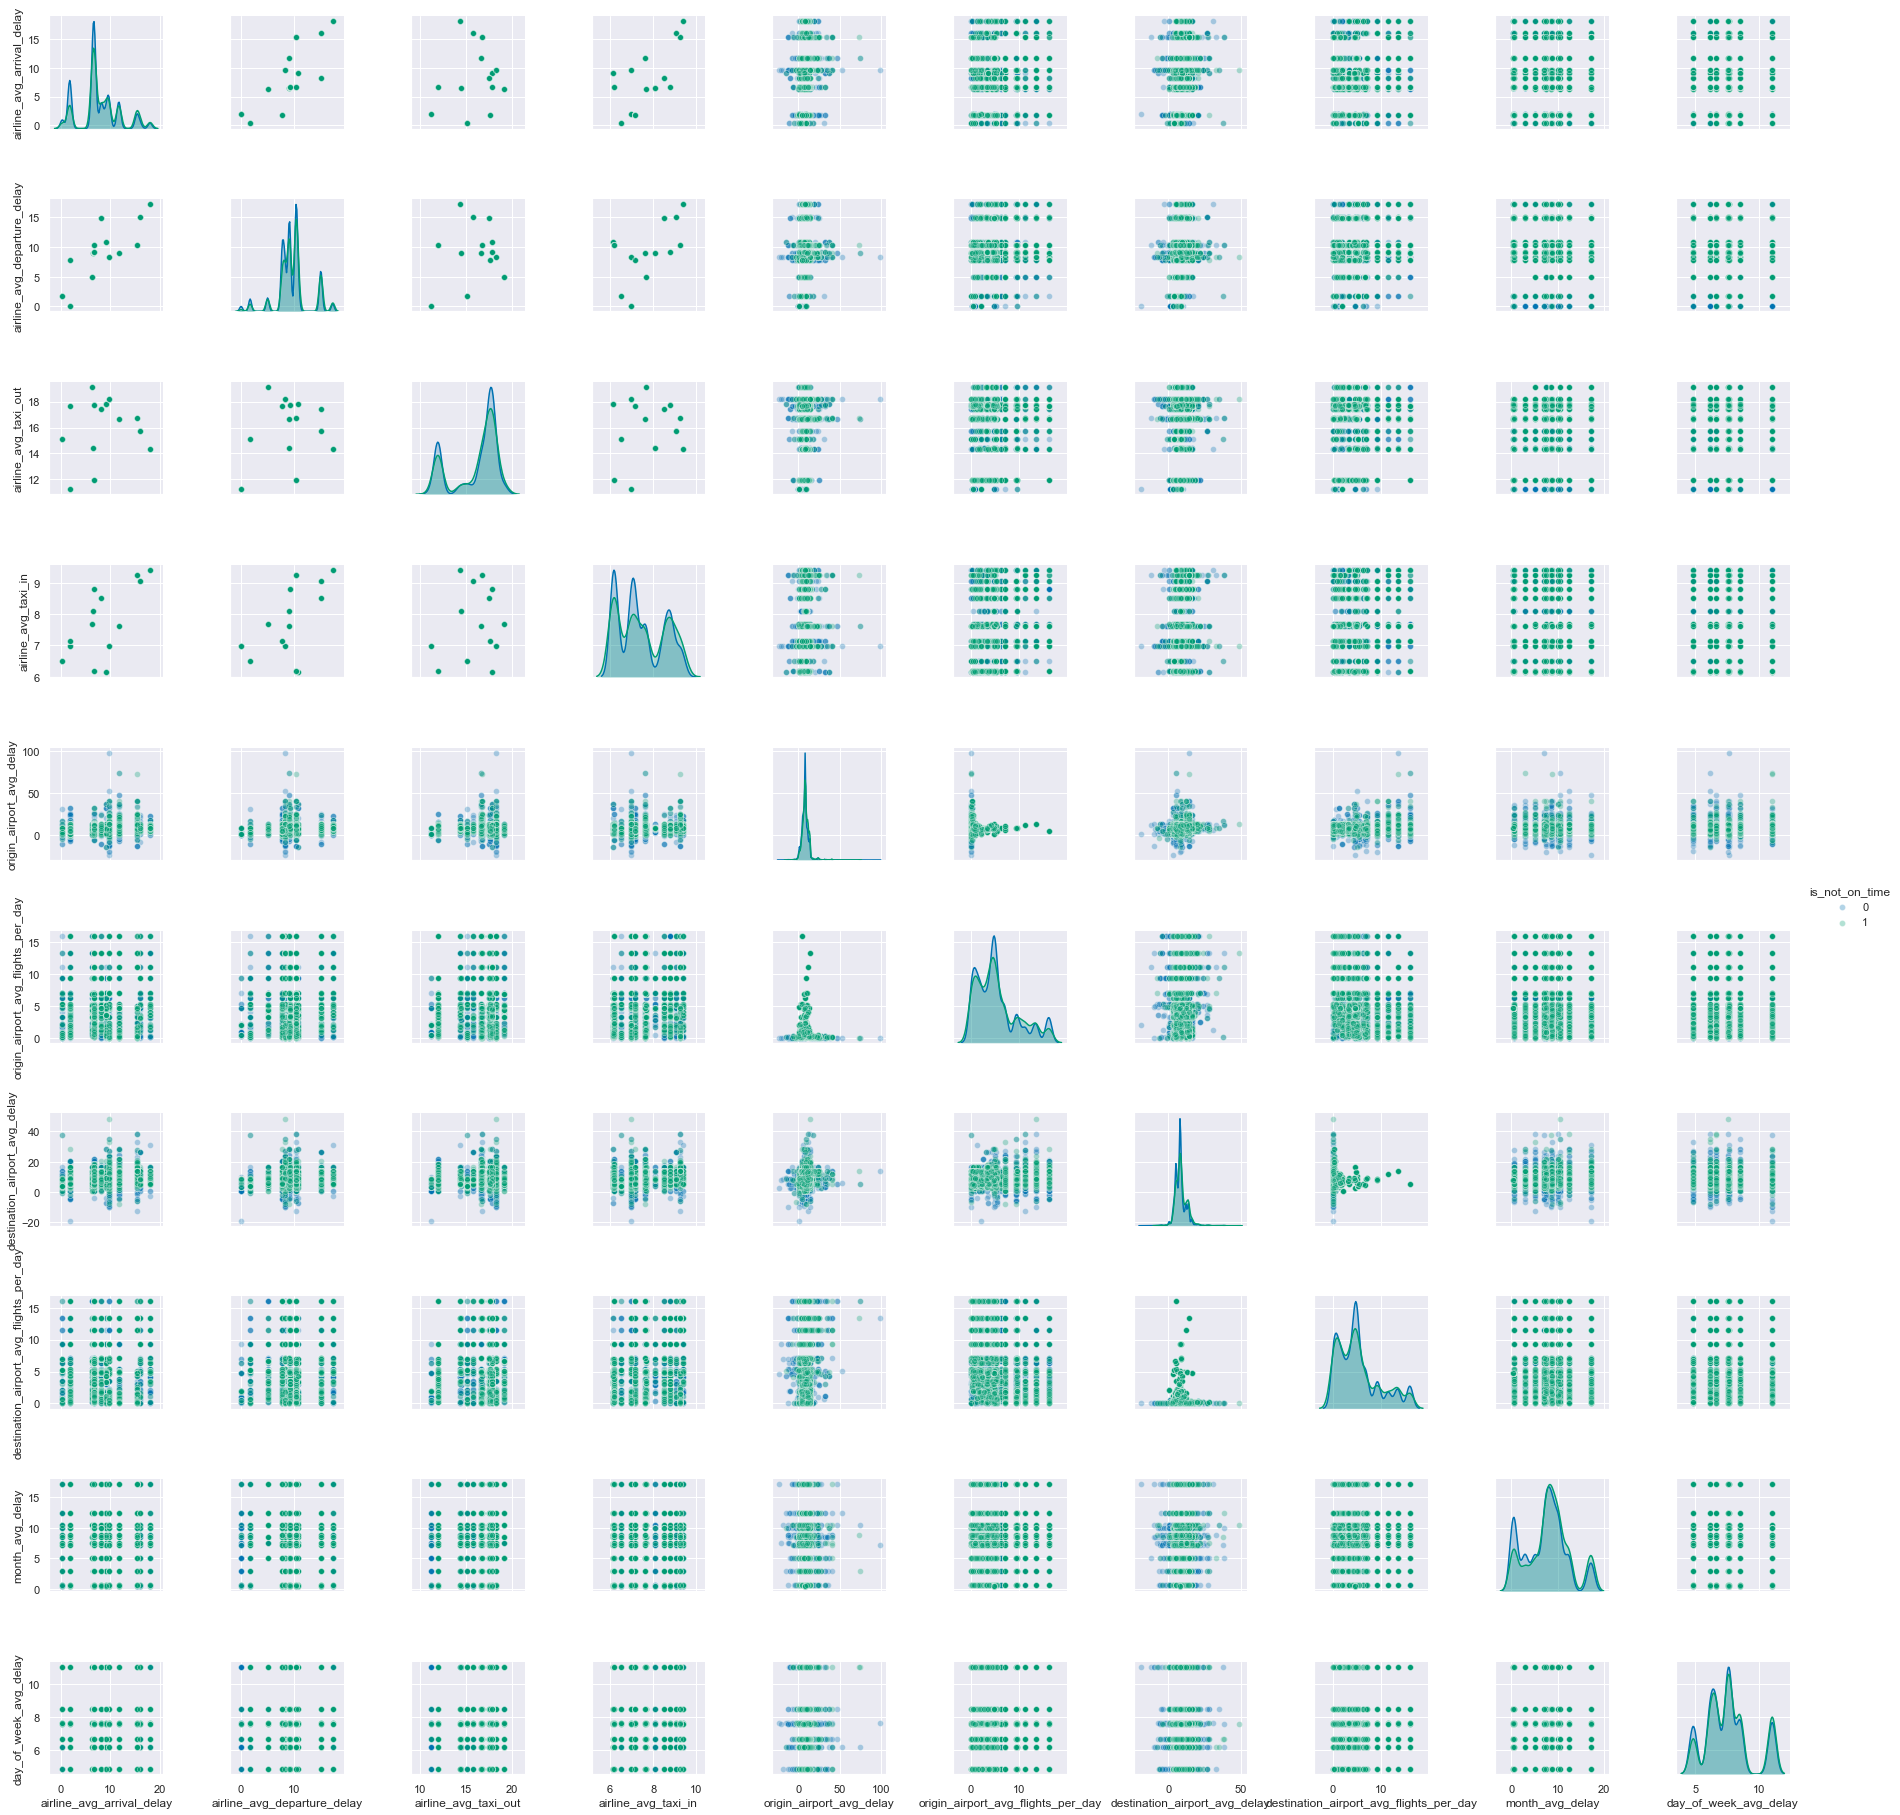

In [512]:
pairplot_features(sample_df[numerical_features + target])

In [569]:
X, y = feature_target_selection(all_features, target, sample_df)

In [570]:
X_train_val, X_test, y_train_val, y_test = initial_split(X, y.values.ravel())
X_train, X_val, y_train, y_val = second_split(X_train_val, y_train_val)

In [571]:
lm = LogisticRegression(penalty='none', max_iter=10000)
lm.fit(X_train_val, y_train_val)

LogisticRegression(max_iter=10000, penalty='none')

In [572]:
cv_records_df = cv(lm, X_train_val, y_train_val, cv_records_df)

Model name: LogisticRegression
Hyperparameters: max_iter=10000, penalty='none'

Mean train F1:             0.013
Mean val F1:               0.013
Mean train precision:      0.487
Mean val precision:        0.484
Mean train recall:         0.006
Mean val recall:           0.006
Mean train accuracy:       0.799
Mean val accuracy:         0.799
Mean train AUC:            0.634
Mean val AUC:              0.633
iteration_desc: 
feature_engineering: took out airline_avg_departure_delay and destination_airport_avg_taxi_in


In [565]:
cv_records_df.tail()

,model,iteration_desc,feature_engineering,hyperparameter_tuning,mean_train_f1,mean_val_f1,mean_train_precision,mean_val_precision,mean_train_recall,mean_val_recall,mean_train_accuracy,mean_val_accuracy,mean_train_AUC,mean_val_AUC
15,LogisticRegression,,"added in airline_avg_departure_delay, airline_...","max_iter=10000, penalty='none'",0.01,0.01,0.47,0.47,8.00e-03,8.00e-03,0.8,0.8,0.63,0.63
16,LogisticRegression,,"took out airline_avg_taxi_out, airline_avg_tax...","max_iter=10000, penalty='none'",0.01,0.01,0.47,0.47,8.00e-03,8.00e-03,0.8,0.8,0.63,0.63
17,LogisticRegression,,"added in origin_airport_avg_departure_delay, o...","max_iter=10000, penalty='none'",0.02,0.01,0.49,0.47,8.00e-03,8.00e-03,0.8,0.8,0.64,0.64
18,LogisticRegression,,"took out origin_airport_avg_taxi_out, origin_a...","max_iter=10000, penalty='none'",0.01,0.01,0.47,0.46,7.00e-03,7.00e-03,0.8,0.8,0.64,0.63
19,LogisticRegression,,added destination_airport_avg_taxi_in,"max_iter=10000, penalty='none'",0.01,0.01,0.48,0.49,6.00e-03,6.00e-03,0.8,0.8,0.63,0.63


In [583]:
def print_model_coef(X, model):
    for feature, coef in zip(X.columns, model.coef_[0]):
        print(f'{feature: <40} {coef:.2f}')

In [584]:
print_model_coef(X_train_val, lm)

airline_avg_arrival_delay                0.04
origin_airport_avg_flights_per_day       0.00
origin_airport_avg_departure_delay       0.04
destination_airport_avg_flights_per_day  0.01
destination_airport_avg_arrival_delay    0.04
month_avg_delay                          0.06
day_of_week_avg_delay                    0.04
American Airlines Inc.                   -0.05
American Eagle Airlines Inc.             -0.13
Atlantic Southeast Airlines              -0.12
Delta Air Lines Inc.                     -0.18
Frontier Airlines Inc.                   0.20
Hawaiian Airlines Inc.                   -0.06
JetBlue Airways                          0.07
Skywest Airlines Inc.                    0.01
Southwest Airlines Co.                   0.09
Spirit Air Lines                         0.11
US Airways Inc.                          -0.11
United Air Lines Inc.                    -0.02
Virgin America                           -0.08
is_thanksgiving_period                   -0.15
is_xmas_period           

In [574]:
lm.predict_proba(X_train)

array([[0.77081946, 0.22918054],
       [0.91947678, 0.08052322],
       [0.8469617 , 0.1530383 ],
       ...,
       [0.90332143, 0.09667857],
       [0.80775649, 0.19224351],
       [0.86876253, 0.13123747]])

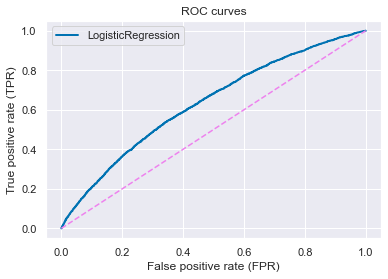

In [575]:
fpr, tpr, thresholds = plot_ROC(lm, X_train, X_val, y_train, y_val)
plt.savefig('roc_curve_project_3.png')

In [576]:
confusion_matrix(y_train_val, lm.predict(X_train_val))

array([[63787,   115],
       [15988,   110]])

In [577]:
get_best_threshold_from_roc_curve(fpr, tpr, thresholds)

(0.1953678483303357, 0.2094692216112425)

In [586]:
split_and_simple_validate(lm, X_train_val, y_train_val, threshold=0.2)

Train F1:                                 0.371
Val F1:                                   0.371
Train precision:                          0.271
Val precision:                            0.270
Train recall:                             0.590
Val recall:                               0.590
Train accuracy:                           0.598
Val accuracy:                             0.596
Train AUC:                                0.595
Val AUC:                                  0.594

Feature coefficients:

airline_avg_arrival_delay                 0.04
origin_airport_avg_flights_per_day        0.00
origin_airport_avg_departure_delay        0.04
destination_airport_avg_flights_per_day   0.01
destination_airport_avg_arrival_delay     0.04
month_avg_delay                           0.06
day_of_week_avg_delay                     0.04
American Airlines Inc.                   -0.05
American Eagle Airlines Inc.             -0.13
Atlantic Southeast Airlines              -0.12
Delta Air Lines Inc.      

LogisticRegression(max_iter=10000, penalty='none')

## Error Analysis ##

In [460]:
error_analysis_df = X_train_val.copy(deep=True)

In [461]:
error_analysis_df['actual_is_not_on_time'] = y_train_val
error_analysis_df['pred_is_not_on_time'] = lm.predict(X_train_val)

In [468]:
cond_list = [((error_analysis_df['actual_is_not_on_time'] == 1) & (error_analysis_df['pred_is_not_on_time'] == 1)),
             ((error_analysis_df['actual_is_not_on_time'] == 0) & (error_analysis_df['pred_is_not_on_time'] == 0)),
             ((error_analysis_df['actual_is_not_on_time'] == 1) & (error_analysis_df['pred_is_not_on_time'] == 0)),
             ((error_analysis_df['actual_is_not_on_time'] == 0) & (error_analysis_df['pred_is_not_on_time'] == 1))] 
cond_values = ['tp', 'tn', 'fn', 'fp']

In [469]:
error_analysis_df['actual_v_pred'] = np.select(cond_list, cond_values)

In [473]:
sample_df.iloc[[46481, 24902, 60199, 18927, 6038]]

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival
46481,2015,5,28,4,DL,17,N126DL,ATL,LAX,1916,1928,12.0,14.0,1942,299,333.0,248.0,1947,2050,71.0,2115,2201,46.0,0,0,None,34.0,0.0,0.0,0.0,12.0,Delta Air Lines Inc.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,33.64,-84.43,Los Angeles International Airport,Los Angeles,CA,33.94,-118.41,1,1.82,34,81,14925,0.77,0,0,0,1,0,0,0,0,0,0,0,0,0,4.91,5857.0,16.05,8.39,3377.0,9.25,1067.0,7.15,852.0,5.71,7.53,8.48,0,0,0,1
24902,2015,4,2,4,WN,1251,N8639B,BWI,JAX,0835,0830,-5.0,18.0,0848,130,119.0,95.0,663,1023,6.0,1045,1029,-16.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,Baltimore-Washington International Airport,Baltimore,MD,39.18,-76.67,Jacksonville International Airport,Jacksonville,FL,30.49,-81.69,0,6.72,62,273,21638,1.55,0,0,0,0,0,0,0,0,1,0,0,0,0,11.83,1496.0,4.10,9.18,285.0,0.78,2490.0,11.51,2737.0,12.65,5.08,8.48,0,0,0,0
60199,2015,11,21,6,UA,228,N75428,SFO,ORD,0641,0657,16.0,83.0,0820,259,339.0,240.0,1846,1420,16.0,1300,1436,96.0,0,0,None,80.0,0.0,16.0,0.0,0.0,United Air Lines Inc.,San Francisco International Airport,San Francisco,CA,37.62,-122.37,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,1,8.19,29,104,8978,1.48,0,0,0,0,0,0,0,0,0,0,0,1,0,8.89,2560.0,7.01,14.01,4910.0,13.45,1153.0,12.84,888.0,9.89,2.96,4.83,0,0,0,0
18927,2015,3,31,2,WN,857,N906WN,MCI,MDW,0950,0948,-2.0,7.0,0955,75,72.0,59.0,405,1054,6.0,1105,1100,-5.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,Kansas City International Airport,Kansas City,MO,39.30,-94.71,Chicago Midway International Airport,Chicago,IL,41.79,-87.75,0,6.72,62,273,21638,1.55,0,0,0,0,0,0,0,0,1,0,0,0,0,4.31,681.0,1.87,7.55,1421.0,3.89,2490.0,11.51,2737.0,12.65,8.49,7.64,0,0,0,0
6038,2015,12,20,7,EV,3827,N12166,IND,IAH,0746,0744,-2.0,10.0,0754,173,157.0,133.0,844,0907,14.0,0939,0921,-18.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Indianapolis International Airport,Indianapolis,IN,39.72,-86.29,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,12.28,431.0,1.18,8.96,2596.0,7.11,902.0,9.13,964.0,9.76,9.97,7.56,0,1,0,0


In [475]:
confusion_matrix(y_train_val, lm.predict(X_train_val))

array([[63770,   132],
       [15977,   121]])

In [474]:
error_analysis_df['actual_v_pred'].value_counts()

tn    63770
fn    15977
fp      132
tp      121
Name: actual_v_pred, dtype: int64

In [479]:
cols = ['actual_is_not_on_time', 'pred_is_not_on_time', 'actual_v_pred'] 

In [485]:
combined_error_analysis_df = sample_df.join(error_analysis_df[cols])

In [483]:
error_analysis_df.sample(5)

,airline_avg_delay,origin_airport_avg_delay,origin_airport_avg_flights_per_day,destination_airport_avg_delay,destination_airport_avg_flights_per_day,month_avg_delay,day_of_week_avg_delay,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival,actual_is_not_on_time,pred_is_not_on_time,actual_v_pred
77001,9.68,-4.51,0.13,2.91,4.55,8.78,6.63,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,tn
14395,6.72,10.39,5.19,5.07,15.99,8.78,7.64,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,fn
6187,11.72,9.18,0.73,8.96,7.11,9.97,7.56,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,tn
8050,11.72,9.92,4.70,11.93,1.60,10.45,7.56,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,fn
70926,9.68,0.62,0.11,8.84,6.94,12.37,7.56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,tn


In [477]:
error_analysis_df[error_analysis_df['actual_v_pred'] == 'fn'].sample(5)

,airline_avg_delay,origin_airport_avg_delay,origin_airport_avg_flights_per_day,destination_airport_avg_delay,destination_airport_avg_flights_per_day,month_avg_delay,day_of_week_avg_delay,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival,actual_is_not_on_time,pred_is_not_on_time,actual_v_pred
11737,6.72,8.64,2.44,8.09,2.92,2.96,7.64,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,fn
33920,6.64,7.92,4.31,8.34,0.37,9.97,7.56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,fn
12641,6.72,6.90,1.39,6.69,1.86,7.53,7.64,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,fn
70401,9.68,16.80,0.35,8.84,6.94,10.45,6.63,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,fn
33275,6.64,8.08,4.68,8.05,4.72,0.41,4.83,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,fn


In [488]:
combined_error_analysis_df[combined_error_analysis_df['actual_v_pred'] == 'fn'].sample(5)

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival,actual_is_not_on_time,pred_is_not_on_time,actual_v_pred
35501,2015,12,28,1,AA,566,N556UW,PHX,MCO,1730,1811,41.0,14.0,1825,235,231.0,207.0,1849,2352,10.0,2325,0002,37.0,0,0,None,0.0,0.0,7.0,30.0,0.0,American Airlines Inc.,Phoenix Sky Harbor International Airport,Phoenix,AZ,33.43,-112.01,Orlando International Airport,Orlando,FL,28.43,-81.32,1,6.64,46,185,12662,1.82,1,0,0,0,0,0,0,0,0,0,0,0,0,6.27,2530.0,6.93,8.23,1867.0,5.12,1166.0,9.21,1006.0,7.95,9.97,11.00,0,0,0,1,1.0,0.0,fn
66111,2015,3,20,5,UA,549,N404UA,PHL,ORD,1620,1917,177.0,25.0,1942,146,140.0,103.0,678,2025,12.0,1746,2037,171.0,0,0,None,0.0,0.0,0.0,153.0,18.0,United Air Lines Inc.,Philadelphia International Airport,Philadelphia,PA,39.87,-75.24,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,1,8.19,29,104,8978,1.48,0,0,0,0,0,0,0,0,0,0,0,1,0,5.84,1162.0,3.18,14.01,4910.0,13.45,1153.0,12.84,888.0,9.89,8.49,6.63,0,0,0,0,1.0,0.0,fn
74603,2015,5,11,1,OO,2772,N906SW,PHX,FAT,1340,1400,20.0,23.0,1423,105,105.0,77.0,493,1540,5.0,1525,1545,20.0,0,0,None,0.0,0.0,0.0,20.0,0.0,Skywest Airlines Inc.,Phoenix Sky Harbor International Airport,Phoenix,AZ,33.43,-112.01,Fresno Yosemite International Airport,Fresno,CA,36.78,-119.72,1,9.68,22,181,10109,2.01,0,0,0,0,0,0,0,1,0,0,0,0,0,6.27,2530.0,6.93,8.21,115.0,0.32,682.0,6.75,1110.0,10.98,7.53,11.00,0,0,0,0,1.0,0.0,fn
7975,2015,10,13,2,EV,4323,N14542,15096,11618,1125,1113,-12.0,56.0,1209,65,107.0,43.0,195,1252,8.0,1230,1300,30.0,0,0,None,30.0,0.0,0.0,0.0,0.0,Atlantic Southeast Airlines,None,None,None,NaN,NaN,None,None,None,NaN,NaN,1,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,8.08,1710.0,4.68,8.05,1721.0,4.72,902.0,9.13,964.0,9.76,0.41,7.64,0,0,0,0,1.0,0.0,fn
73378,2015,11,28,6,OO,5338,N494CA,LAX,MRY,1838,1847,9.0,33.0,1920,72,82.0,45.0,266,2005,4.0,1950,2009,19.0,0,0,None,10.0,0.0,0.0,9.0,0.0,Skywest Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,33.94,-118.41,Monterey Regional Airport (Monterey Peninsula ...,Monterey,CA,36.59,-121.84,1,9.68,22,181,10109,2.01,0,0,0,0,0,0,0,1,0,0,0,0,0,8.61,3441.0,9.43,10.47,55.0,0.15,682.0,6.75,1110.0,10.98,2.96,4.83,1,0,0,0,1.0,0.0,fn
